In [20]:
# TASK 5 - HANDWRITTEN TEXT GENERATION - MODEL TRAINING
# CodSoft Machine Learning Internship
# Author: Chandan Kumar | Batch: December 2025 B68

"""
📘 Project: Handwritten Text Generation - Model Training
🎯 Objective: Train RNN, LSTM, and GRU models for text generation
📊 Models: Simple RNN, LSTM, GRU
"""

# PART 1: IMPORTS AND SETUP

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.optimizers import Adam

# Utilities
import pickle
import os
from datetime import datetime
import time

In [21]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries imported successfully!")
print(f"📊 TensorFlow Version: {tf.__version__}")
print(f"🎯 GPU Available: {len(tf.config.list_physical_devices('GPU'))} GPU(s)")
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully!
📊 TensorFlow Version: 2.20.0
🎯 GPU Available: 0 GPU(s)
📅 Date: 2025-12-20 16:52:44


In [22]:
# PART 2: LOAD PREPROCESSED DATA

print("\n" + "="*80)
print("📂 LOADING PREPROCESSED DATA")
print("="*80)

print("🔄 Loading training data...")
X = np.load('../artifacts/X_sequences.npy')
y = np.load('../artifacts/y_targets.npy')

print(f"✅ X shape: {X.shape}")
print(f"✅ y shape: {y.shape}")

print("\n🔄 Loading character mappings...")
with open('../artifacts/char_mappings.pkl', 'rb') as f:
    mappings = pickle.load(f)

char_to_idx = mappings['char_to_idx']
idx_to_char = mappings['idx_to_char']
chars = mappings['chars']
n_chars = mappings['n_chars']
seq_length = mappings['seq_length']

print(f"✅ Vocabulary size: {n_chars}")
print(f"✅ Sequence length: {seq_length}")


📂 LOADING PREPROCESSED DATA
🔄 Loading training data...
✅ X shape: (95876, 100, 54)
✅ y shape: (95876, 54)

🔄 Loading character mappings...
✅ Vocabulary size: 54
✅ Sequence length: 100


In [23]:
# Load metadata
metadata = pd.read_csv('../artifacts/preprocessing_metadata.csv')
print("\n📊 Dataset Metadata:")
print(metadata.T)


📊 Dataset Metadata:
                                            0
dataset_name        corto-ai/handwritten-text
split_used                              train
total_samples                            6482
text_field                               text
total_text_length                      287726
vocabulary_size                            54
num_sequences                           95876
sequence_length                           100
step_size                                   3
num_documents                            6482
preprocessing_date        2025-12-20 16:51:17


In [24]:
# PART 3: TEXT GENERATION HELPER FUNCTIONS

print("\n" + "="*80)
print("🔧 SETTING UP HELPER FUNCTIONS")
print("="*80)

def sample_with_temperature(preds, temperature=1.0):
    """
    Sample an index from a probability array with temperature
    
    Args:
        preds: Probability array
        temperature: Higher = more random, Lower = more deterministic
    
    Returns:
        Sampled index
    """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text(model, seed_text, length=200, temperature=1.0):
    """
    Generate text using trained model
    
    Args:
        model: Trained Keras model
        seed_text: Starting text
        length: Number of characters to generate
        temperature: Sampling temperature
    
    Returns:
        Generated text
    """
    generated = seed_text.lower()
    seed = seed_text.lower()
    
    # Pad seed if too short
    if len(seed) < seq_length:
        seed = ' ' * (seq_length - len(seed)) + seed
    
    for i in range(length):
        # Prepare input
        x_pred = np.zeros((1, seq_length, n_chars))
        for t, char in enumerate(seed[-seq_length:]):
            if char in char_to_idx:
                x_pred[0, t, char_to_idx[char]] = 1
        
        # Predict
        preds = model.predict(x_pred, verbose=0)[0]
        next_idx = sample_with_temperature(preds, temperature)
        next_char = idx_to_char[next_idx]
        
        generated += next_char
        seed += next_char
    
    return generated

def test_generation(model, model_name, seeds, temperature=0.8):
    """Test text generation with multiple seeds"""
    print(f"\n{'='*80}")
    print(f"🎨 TEXT GENERATION TEST - {model_name}")
    print(f"{'='*80}")
    
    for i, seed in enumerate(seeds, 1):
        print(f"\n--- Sample {i} (Temperature={temperature}) ---")
        print(f"Seed: '{seed}'")
        print(f"\nGenerated:")
        generated = generate_text(model, seed, length=200, temperature=temperature)
        print(generated)
        print("-" * 80)

print("✅ Helper functions defined")


🔧 SETTING UP HELPER FUNCTIONS
✅ Helper functions defined


In [25]:
# PART 4: MODEL ARCHITECTURES

print("\n" + "="*80)
print("🏗️  BUILDING MODEL ARCHITECTURES")
print("="*80)

# Model parameters
hidden_units = 256
dropout_rate = 0.3
learning_rate = 0.001


🏗️  BUILDING MODEL ARCHITECTURES


In [26]:
# MODEL 1: Simple RNN

print("\n📐 Model 1: Simple RNN")
print("-" * 60)

model_rnn = Sequential([
    SimpleRNN(hidden_units, 
              input_shape=(seq_length, n_chars),
              return_sequences=True,
              name='rnn_layer_1'),
    Dropout(dropout_rate, name='dropout_1'),
    SimpleRNN(hidden_units, name='rnn_layer_2'),
    Dropout(dropout_rate, name='dropout_2'),
    Dense(n_chars, activation='softmax', name='output')
], name='SimpleRNN_Model')

model_rnn.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

print(model_rnn.summary())
print(f"📊 Total Parameters: {model_rnn.count_params():,}")


📐 Model 1: Simple RNN
------------------------------------------------------------


Model: "SimpleRNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_layer_1 (SimpleRNN)         │ (None, 100, 256)       │        79,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_2 (SimpleRNN)         │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 54)             │        13,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 224,822 (878.21 KB)

 Trainable params: 224,822 (878.21 KB)

 Non-trainable params: 0 (0.00 B)

None
📊 Total Parameters: 224,822


In [27]:
# MODEL 2: LSTM

print("\n📐 Model 2: LSTM")
print("-" * 60)

model_lstm = Sequential([
    LSTM(hidden_units, 
         input_shape=(seq_length, n_chars),
         return_sequences=True,
         name='lstm_layer_1'),
    Dropout(dropout_rate, name='dropout_1'),
    LSTM(hidden_units, name='lstm_layer_2'),
    Dropout(dropout_rate, name='dropout_2'),
    Dense(n_chars, activation='softmax', name='output')
], name='LSTM_Model')

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

print(model_lstm.summary())
print(f"📊 Total Parameters: {model_lstm.count_params():,}")


📐 Model 2: LSTM
------------------------------------------------------------


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer_1 (LSTM)             │ (None, 100, 256)       │       318,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 54)             │        13,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 857,654 (3.27 MB)

 Trainable params: 857,654 (3.27 MB)

 Non-trainable params: 0 (0.00 B)

None
📊 Total Parameters: 857,654


In [28]:
# MODEL 3: GRU

print("\n📐 Model 3: GRU")
print("-" * 60)

model_gru = Sequential([
    GRU(hidden_units, 
        input_shape=(seq_length, n_chars),
        return_sequences=True,
        name='gru_layer_1'),
    Dropout(dropout_rate, name='dropout_1'),
    GRU(hidden_units, name='gru_layer_2'),
    Dropout(dropout_rate, name='dropout_2'),
    Dense(n_chars, activation='softmax', name='output')
], name='GRU_Model')

model_gru.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

print(model_gru.summary())
print(f"📊 Total Parameters: {model_gru.count_params():,}")


📐 Model 3: GRU
------------------------------------------------------------


Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_layer_1 (GRU)               │ (None, 100, 256)       │       239,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_layer_2 (GRU)               │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 54)             │        13,878 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,246 (2.47 MB)

 Trainable params: 648,246 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

None
📊 Total Parameters: 648,246


In [29]:
# Model comparison
print("\n" + "="*80)
print("📊 MODEL COMPARISON")
print("="*80)
print(f"{'Model':<15} {'Parameters':<15} {'Layers':<10}")
print("-" * 60)
print(f"{'Simple RNN':<15} {model_rnn.count_params():<15,} {len(model_rnn.layers):<10}")
print(f"{'LSTM':<15} {model_lstm.count_params():<15,} {len(model_lstm.layers):<10}")
print(f"{'GRU':<15} {model_gru.count_params():<15,} {len(model_gru.layers):<10}")


📊 MODEL COMPARISON
Model           Parameters      Layers    
------------------------------------------------------------
Simple RNN      224,822         5         
LSTM            857,654         5         
GRU             648,246         5         


In [30]:
# PART 5: TRAINING CONFIGURATION

print("\n" + "="*80)
print("⚙️  TRAINING CONFIGURATION")
print("="*80)

# Training parameters
epochs = 30
batch_size = 128
validation_split = 0.1

print(f"📊 Training Configuration:")
print(f"  • Epochs:            {epochs}")
print(f"  • Batch Size:        {batch_size}")
print(f"  • Validation Split:  {validation_split}")
print(f"  • Learning Rate:     {learning_rate}")
print(f"  • Hidden Units:      {hidden_units}")
print(f"  • Dropout Rate:      {dropout_rate}")

# ===============================
# CALLBACKS
# ===============================

callbacks_rnn = [
    ModelCheckpoint(
        filepath="../models/rnn_model_best.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

callbacks_lstm = [
    ModelCheckpoint(
        filepath="../models/lstm_model_best.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

callbacks_gru = [
    ModelCheckpoint(
        filepath="../models/gru_model_best.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

print("✅ Callbacks configured successfully")


⚙️  TRAINING CONFIGURATION
📊 Training Configuration:
  • Epochs:            30
  • Batch Size:        128
  • Validation Split:  0.1
  • Learning Rate:     0.001
  • Hidden Units:      256
  • Dropout Rate:      0.3
✅ Callbacks configured successfully


In [32]:
# PART 6: TRAIN MODELS

print("🚀 TRAINING MODELS")

training_results = {}

# Train Simple RNN

print("\n" + "="*80)
print("🔥 TRAINING SIMPLE RNN")
print("="*80)

start_time = time.time()

history_rnn = model_rnn.fit(
    X, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks_rnn,
    verbose=1
)

rnn_time = time.time() - start_time
training_results['rnn'] = {
    'history': history_rnn,
    'time': rnn_time
}

print(f"\n✅ Simple RNN training complete!")
print(f"⏱️  Training time: {rnn_time/60:.2f} minutes")

🚀 TRAINING MODELS

🔥 TRAINING SIMPLE RNN
Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.1258 - loss: 3.3133
Epoch 1: val_loss improved from None to 3.00163, saving model to ../models/rnn_model_best.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 209s 310ms/step - accuracy: 0.1312 - loss: 3.2450 - val_accuracy: 0.1927 - val_loss: 3.0016 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.1739 - loss: 3.0109
Epoch 2: val_loss improved from 3.00163 to 2.60990, saving model to ../models/rnn_model_best.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 195s 289ms/step - accuracy: 0.2010 - loss: 2.8926 - val_accuracy: 0.2622 - val_loss: 2.6099 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.2434 - loss: 2.7323
Epoch 3: val_loss improved from 2.60990 to 2.49947, saving model to ../models/rnn_model_best.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 212s 313ms/step - accuracy: 0.2510 - loss: 2.7017 - val_accuracy: 0.2815 - val_los

In [33]:
# Train LSTM

print("\n" + "="*80)
print("🔥 TRAINING LSTM")
print("="*80)

start_time = time.time()

history_lstm = model_lstm.fit(
    X, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks_lstm,
    verbose=1
)

lstm_time = time.time() - start_time
training_results['lstm'] = {
    'history': history_lstm,
    'time': lstm_time
}

print(f"\n✅ LSTM training complete!")
print(f"⏱️  Training time: {lstm_time/60:.2f} minutes")


🔥 TRAINING LSTM
Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1885 - loss: 2.9541
Epoch 1: val_loss improved from None to 2.38419, saving model to ../models/lstm_model_best.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 819s 1s/step - accuracy: 0.2423 - loss: 2.7027 - val_accuracy: 0.3137 - val_loss: 2.3842 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3294 - loss: 2.3140
Epoch 2: val_loss improved from 2.38419 to 2.18582, saving model to ../models/lstm_model_best.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 776s 1s/step - accuracy: 0.3398 - loss: 2.2614 - val_accuracy: 0.3563 - val_loss: 2.1858 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3727 - loss: 2.1334
Epoch 3: val_loss improved from 2.18582 to 2.09354, saving model to ../models/lstm_model_best.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 777s 1s/step - accuracy: 0.3788 - loss: 2.1008 - val_accuracy: 0.3794 - val_loss: 2.0935 - learning_rate: 0.0010
Epoch

In [34]:
# Train GRU

print("\n" + "="*80)
print("🔥 TRAINING GRU")
print("="*80)

start_time = time.time()

history_gru = model_gru.fit(
    X, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks_gru,
    verbose=1
)

gru_time = time.time() - start_time
training_results['gru'] = {
    'history': history_gru,
    'time': gru_time
}

print(f"\n✅ GRU training complete!")
print(f"⏱️  Training time: {gru_time/60:.2f} minutes")


🔥 TRAINING GRU
Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.2419 - loss: 2.7378
Epoch 1: val_loss improved from None to 2.22803, saving model to ../models/gru_model_best.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 574s 842ms/step - accuracy: 0.2950 - loss: 2.4645 - val_accuracy: 0.3511 - val_loss: 2.2280 - learning_rate: 0.0010
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.3624 - loss: 2.1727
Epoch 2: val_loss improved from 2.22803 to 2.10202, saving model to ../models/gru_model_best.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 564s 835ms/step - accuracy: 0.3720 - loss: 2.1303 - val_accuracy: 0.3809 - val_loss: 2.1020 - learning_rate: 0.0010
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.4018 - loss: 2.0185
Epoch 3: val_loss improved from 2.10202 to 2.02108, saving model to ../models/gru_model_best.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 573s 849ms/step - accuracy: 0.4076 - loss: 1.9877 - val_accuracy: 0.3992 - val_loss: 2.0211 - learning_rate


📊 VISUALIZING TRAINING RESULTS
✅ Saved: images/training_loss_comparison.png


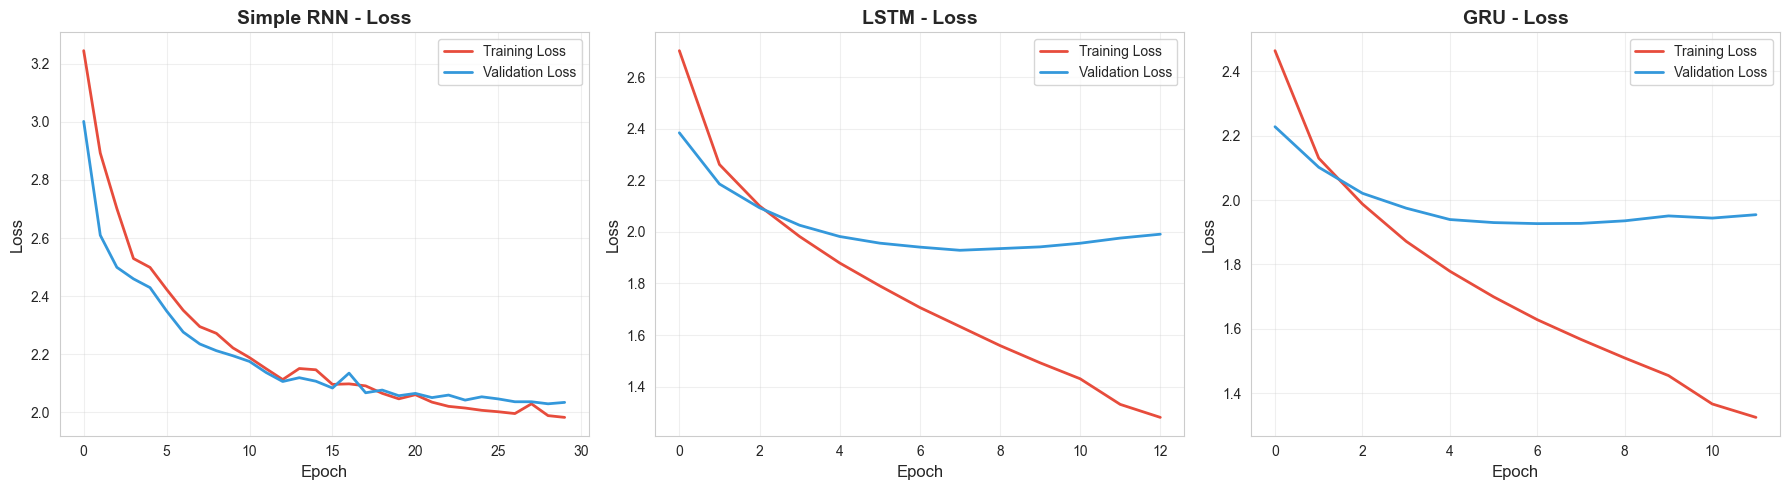

✅ Saved: images/training_accuracy_comparison.png


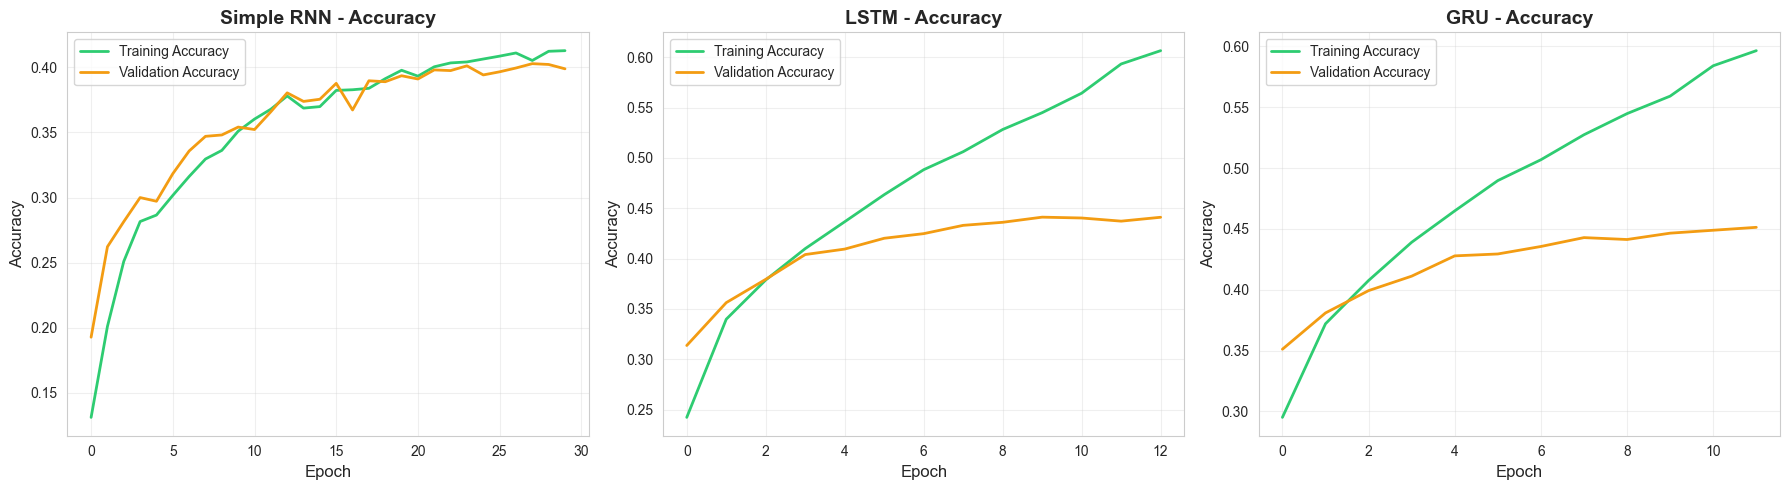

✅ Saved: images/model_comparison.png


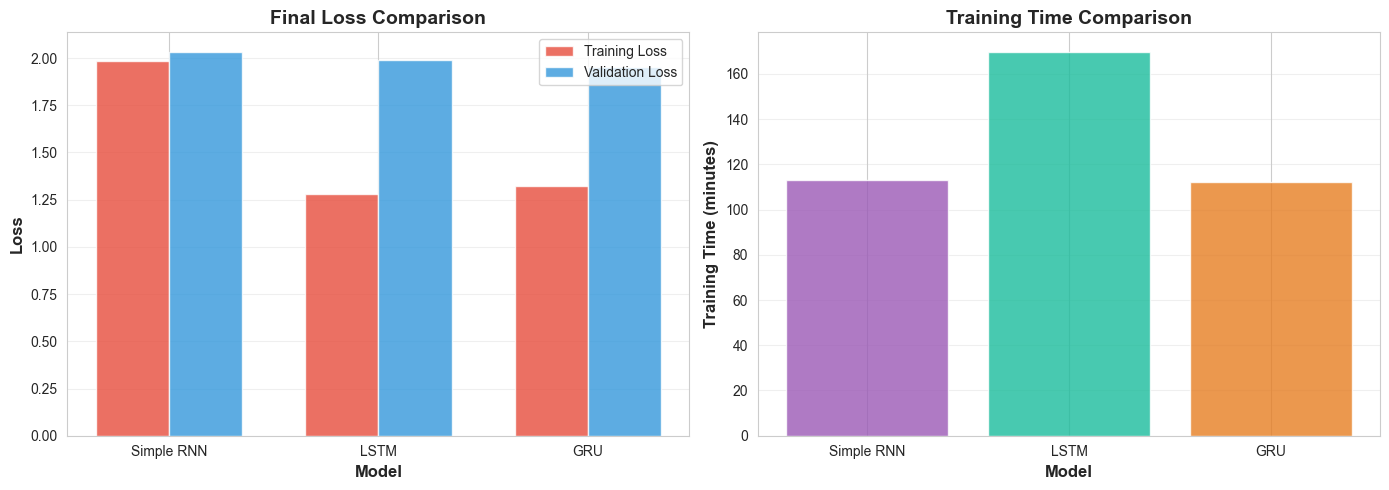

In [35]:
# PART 7: TRAINING RESULTS VISUALIZATION

print("\n" + "="*80)
print("📊 VISUALIZING TRAINING RESULTS")
print("="*80)

# Figure 1: Training and Validation Loss
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Simple RNN
axes[0].plot(history_rnn.history['loss'], label='Training Loss', linewidth=2, color='#e74c3c')
axes[0].plot(history_rnn.history['val_loss'], label='Validation Loss', linewidth=2, color='#3498db')
axes[0].set_title('Simple RNN - Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# LSTM
axes[1].plot(history_lstm.history['loss'], label='Training Loss', linewidth=2, color='#e74c3c')
axes[1].plot(history_lstm.history['val_loss'], label='Validation Loss', linewidth=2, color='#3498db')
axes[1].set_title('LSTM - Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# GRU
axes[2].plot(history_gru.history['loss'], label='Training Loss', linewidth=2, color='#e74c3c')
axes[2].plot(history_gru.history['val_loss'], label='Validation Loss', linewidth=2, color='#3498db')
axes[2].set_title('GRU - Loss', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Loss', fontsize=12)
axes[2].legend(fontsize=10)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../images/training_loss_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Saved: images/training_loss_comparison.png")
plt.show()

# Figure 2: Training and Validation Accuracy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Simple RNN
axes[0].plot(history_rnn.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2ecc71')
axes[0].plot(history_rnn.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#f39c12')
axes[0].set_title('Simple RNN - Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# LSTM
axes[1].plot(history_lstm.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2ecc71')
axes[1].plot(history_lstm.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#f39c12')
axes[1].set_title('LSTM - Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

# GRU
axes[2].plot(history_gru.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2ecc71')
axes[2].plot(history_gru.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#f39c12')
axes[2].set_title('GRU - Accuracy', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('Accuracy', fontsize=12)
axes[2].legend(fontsize=10)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../images/training_accuracy_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Saved: images/training_accuracy_comparison.png")
plt.show()

# Figure 3: Model Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Final Loss Comparison
models_names = ['Simple RNN', 'LSTM', 'GRU']
train_losses = [
    history_rnn.history['loss'][-1],
    history_lstm.history['loss'][-1],
    history_gru.history['loss'][-1]
]
val_losses = [
    history_rnn.history['val_loss'][-1],
    history_lstm.history['val_loss'][-1],
    history_gru.history['val_loss'][-1]
]

x = np.arange(len(models_names))
width = 0.35

axes[0].bar(x - width/2, train_losses, width, label='Training Loss', color='#e74c3c', alpha=0.8)
axes[0].bar(x + width/2, val_losses, width, label='Validation Loss', color='#3498db', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0].set_title('Final Loss Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models_names)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Training Time Comparison
training_times = [rnn_time/60, lstm_time/60, gru_time/60]
axes[1].bar(models_names, training_times, color=['#9b59b6', '#1abc9c', '#e67e22'], alpha=0.8)
axes[1].set_xlabel('Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Training Time (minutes)', fontsize=12, fontweight='bold')
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../images/model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Saved: images/model_comparison.png")
plt.show()


In [36]:
# PART 8: PERFORMANCE SUMMARY

print("\n" + "="*80)
print("📊 TRAINING PERFORMANCE SUMMARY")
print("="*80)

print(f"\n{'Model':<15} {'Train Loss':<12} {'Val Loss':<12} {'Train Acc':<12} {'Val Acc':<12} {'Time (min)':<12}")
print("-" * 85)
print(f"{'Simple RNN':<15} {history_rnn.history['loss'][-1]:<12.4f} {history_rnn.history['val_loss'][-1]:<12.4f} {history_rnn.history['accuracy'][-1]:<12.4f} {history_rnn.history['val_accuracy'][-1]:<12.4f} {rnn_time/60:<12.2f}")
print(f"{'LSTM':<15} {history_lstm.history['loss'][-1]:<12.4f} {history_lstm.history['val_loss'][-1]:<12.4f} {history_lstm.history['accuracy'][-1]:<12.4f} {history_lstm.history['val_accuracy'][-1]:<12.4f} {lstm_time/60:<12.2f}")
print(f"{'GRU':<15} {history_gru.history['loss'][-1]:<12.4f} {history_gru.history['val_loss'][-1]:<12.4f} {history_gru.history['accuracy'][-1]:<12.4f} {history_gru.history['val_accuracy'][-1]:<12.4f} {gru_time/60:<12.2f}")


📊 TRAINING PERFORMANCE SUMMARY

Model           Train Loss   Val Loss     Train Acc    Val Acc      Time (min)  
-------------------------------------------------------------------------------------
Simple RNN      1.9830       2.0346       0.4128       0.3988       113.17      
LSTM            1.2807       1.9910       0.6065       0.4411       169.90      
GRU             1.3243       1.9545       0.5965       0.4513       112.39      


In [37]:
# PART 9: TEXT GENERATION TESTING

print("\n" + "="*80)
print("🎨 TESTING TEXT GENERATION")
print("="*80)

# Test seeds
test_seeds = [
    "deep learning",
    "the quick brown",
    "handwritten text"
]

# Test each model
test_generation(model_rnn, "Simple RNN", test_seeds, temperature=0.8)
test_generation(model_lstm, "LSTM", test_seeds, temperature=0.8)
test_generation(model_gru, "GRU", test_seeds, temperature=0.8)

# PART 10: SAVE MODELS AND RESULTS

print("\n" + "="*80)
print("💾 SAVING MODELS AND RESULTS")
print("="*80)

# Save final models
model_rnn.save('../models/rnn_model_final.keras')
print("✅ Saved: models/rnn_model_final.keras")

model_lstm.save('../models/lstm_model_final.keras')
print("✅ Saved: models/lstm_model_final.keras")

model_gru.save('../models/gru_model_final.keras')
print("✅ Saved: models/gru_model_final.keras")

# Save training histories
with open('../artifacts/training_histories.pkl', 'wb') as f:
    pickle.dump({
        'rnn': history_rnn.history,
        'lstm': history_lstm.history,
        'gru': history_gru.history
    }, f)
print("✅ Saved: artifacts/training_histories.pkl")

# Save results summary
results_df = pd.DataFrame({
    'Model': ['Simple RNN', 'LSTM', 'GRU'],
    'Train_Loss': [history_rnn.history['loss'][-1], history_lstm.history['loss'][-1], history_gru.history['loss'][-1]],
    'Val_Loss': [history_rnn.history['val_loss'][-1], history_lstm.history['val_loss'][-1], history_gru.history['val_loss'][-1]],
    'Train_Accuracy': [history_rnn.history['accuracy'][-1], history_lstm.history['accuracy'][-1], history_gru.history['accuracy'][-1]],
    'Val_Accuracy': [history_rnn.history['val_accuracy'][-1], history_lstm.history['val_accuracy'][-1], history_gru.history['val_accuracy'][-1]],
    'Training_Time_Minutes': [rnn_time/60, lstm_time/60, gru_time/60],
    'Parameters': [model_rnn.count_params(), model_lstm.count_params(), model_gru.count_params()]
})

results_df.to_csv('../artifacts/training_results.csv', index=False)
print("✅ Saved: artifacts/training_results.csv")

print("\n🎉 MODEL TRAINING COMPLETE!")
print("📝 Next step: Run app.py to use the text generation web interface")


🎨 TESTING TEXT GENERATION

🎨 TEXT GENERATION TEST - Simple RNN

--- Sample 1 (Temperature=0.8) ---
Seed: 'deep learning'

Generated:
deep learning the fastrias bealty cunled and helt at che fermanist since - luse furationt that
that in is being ot which we west
had it morust of and whwen , sotpect of but wallyquanisians . " is the exunhed browf
--------------------------------------------------------------------------------

--- Sample 2 (Temperature=0.8) ---
Seed: 'the quick brown'

Generated:
the quick brown who the
sond the componal of chise dired of but the
that the ondlist on the his the thild by the for that
it as it was was iche brought and he whor it is is been been revite
arjen and whis sight bewo
--------------------------------------------------------------------------------

--- Sample 3 (Temperature=0.8) ---
Seed: 'handwritten text'

Generated:
handwritten textion and but been will the
lovioned that that a sullons indeed to his negies wend
to who bowatter of the ippiais e